<a href="https://colab.research.google.com/github/Pablobm3/Detector-de-Balsas/blob/main/tiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
!pip install rasterio
import rasterio
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from skimage import exposure
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cv2


# Definir la ruta base a la carpeta de imágenes
ruta_base = '/content/drive/MyDrive/imagenes_balsas/tif'

# Iterar sobre las carpetas de imágenes (img1, img2, etc.)
for i in range(1, 6):  # Ajusta el rango según la cantidad de carpetas
    carpeta_imagen = os.path.join(ruta_base, f'Balsa{i}')

    # Construir las rutas a las bandas
    ruta_imagen = os.path.join(carpeta_imagen, f'Balsa{i}.tiff')
    ruta_banda3 = os.path.join(carpeta_imagen, f'Balsa{i}_B03.tiff')
    ruta_banda8 = os.path.join(carpeta_imagen, f'Balsa{i}_B08.tiff')
    ruta_banda1 = os.path.join(carpeta_imagen, f'Balsa{i}_B01.tiff')

    # Cargar las bandas (si existen)
    try:
        banda3 = np.asarray(Image.open(ruta_banda3))
        banda8 = np.asarray(Image.open(ruta_banda8))
        banda1 = np.asarray(Image.open(ruta_banda1))
    except FileNotFoundError:
        print(f"No se encontraron las bandas para la imagen {i}. Saltando...")
        continue

    # Calcular NDWI
    ndwi = (banda3 - banda8) / (banda3 + banda8)

    # Ajustar el umbral (experimenta con diferentes valores)
    umbral_ndwi = 0.8

    # Crear máscara de agua
    mascara_agua = ndwi > umbral_ndwi

    # Combinar la máscara con la imagen original
    imagen_balsas = np.copy(banda1)
    imagen_balsas[mascara_agua] = 255

    # Aplicar operaciones morfológicas (opcional)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    mascara_morfo = cv2.morphologyEx(imagen_balsas, cv2.MORPH_OPEN, kernel)
    mascara_morfo = cv2.morphologyEx(mascara_morfo, cv2.MORPH_CLOSE, kernel)

    # Guardar la máscara en formato JPG
    ruta_mascara = os.path.join('/content/drive/MyDrive/imagenes_balsas/Mascaras/tiff', f'Mask{i}.jpg')

    Image.fromarray(mascara_morfo).convert('L').save(ruta_mascara)

    # print(f"Máscara de la imagen {i} creada y guardada en: {ruta_mascara}")




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 39.7 MB/s eta 0:00:00


<ipython-input-1-49da51e8dbdb>:39: RuntimeWarning: divide by zero encountered in divide
  ndwi = (banda3 - banda8) / (banda3 + banda8)


(-0.5, 733.5, 369.5, -0.5)

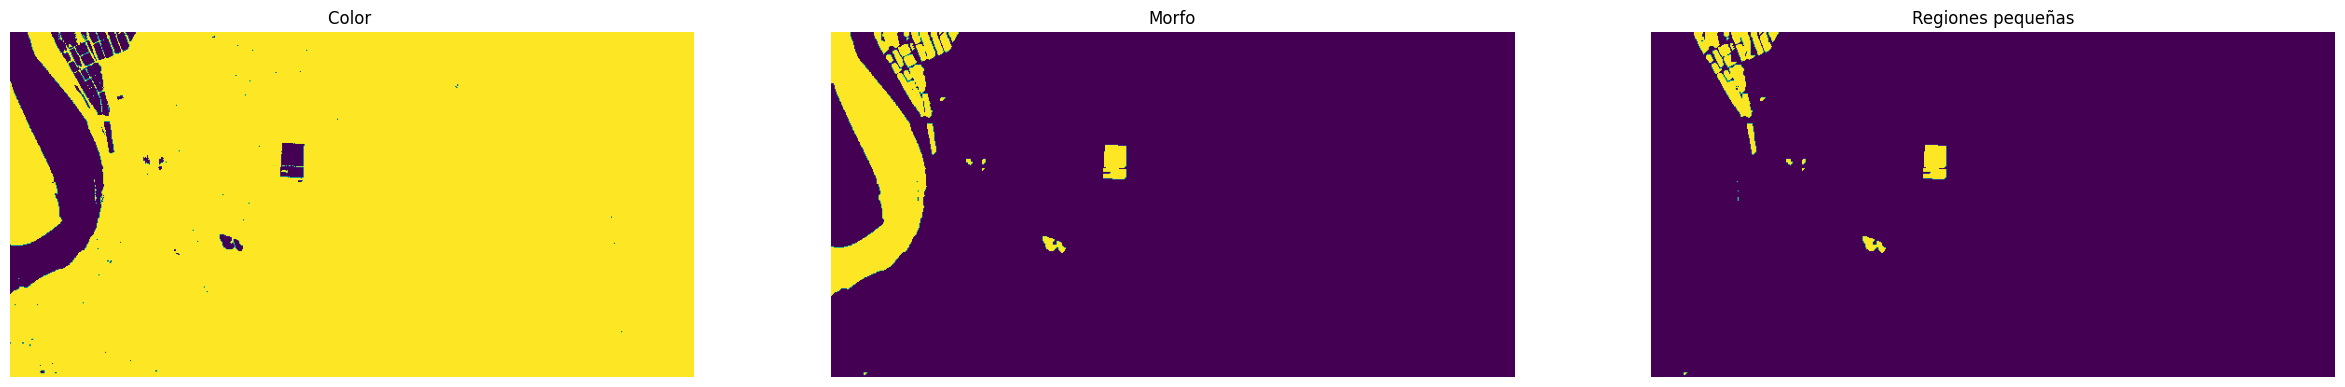

In [53]:
    from skimage.measure import label, regionprops
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import cv2
    from skimage import measure
    from skimage.morphology import remove_small_objects

    # Definir la ruta base a la carpeta de imágenes
    ruta_base = '/content/drive/MyDrive/imagenes_balsas/tif'

    i=7
    carpeta_imagen = os.path.join(ruta_base, f'Balsa{i}')


    # Construir las rutas a las bandas
    ruta_imagen = os.path.join(carpeta_imagen, f'Balsa{i}.tiff')
    ruta_banda3 = os.path.join(carpeta_imagen, f'Balsa{i}_B03.tiff')
    ruta_banda8 = os.path.join(carpeta_imagen, f'Balsa{i}_B08.tiff')
    ruta_banda1 = os.path.join(carpeta_imagen, f'Balsa{i}_B01.tiff')



    # Cargar las bandas
    img= np.asarray(Image.open(ruta_imagen))
    banda3 = np.asarray(Image.open(ruta_banda3))
    banda8 = np.asarray(Image.open(ruta_banda8))
    banda1 = np.asarray(Image.open(ruta_banda1))

    # Calcular NDWI
    ndwi = (banda3 - banda8) / (banda3 + banda8)

    # Ajustar el umbral (experimenta con diferentes valores)
    umbral_ndwi = 0.8
    #umbral_ndwi = np.mean(ndwi) + 2 * np.std(ndwi)

    #umbral_ndvi = 0.8

    # Crear máscara de agua
    mascara_agua = ndwi > umbral_ndwi
    #mascara_agua = (ndwi > umbral_ndwi) & (ndvi < umbral_ndvi)





    # Aplicar operaciones morfológicas (opcional)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    mascara_close = cv2.morphologyEx(mascara_agua.astype(np.uint8), cv2.MORPH_CLOSE, kernel,iterations=2)
    mascara_open = cv2.morphologyEx(mascara_agua.astype(np.uint8), cv2.MORPH_OPEN, kernel,iterations=2)
    mascara_combinada = cv2.bitwise_or(mascara_close, mascara_open)
    mascara_combinada = cv2.bitwise_not(mascara_combinada)


        # Etiquetar regiones
    labeled_mask = measure.label(mascara_combinada)

        # Calcular propiedades de las regiones
    regions = regionprops(labeled_mask)


    # Definir el umbral de área como un porcentaje del área total
    area_threshold = 6000

    # Filtrar regiones por área
    filtered_regions = [region for region in regions if region.area < area_threshold]

    # Crear nueva máscara
    filtered_mask = np.zeros_like(mascara_combinada, dtype=bool)
    for region in filtered_regions:
        # Obtener las coordenadas de la región
        minr, minc, maxr, maxc = region.bbox
        # Asignar True a la nueva máscara en las coordenadas de la región
        filtered_mask[minr:maxr, minc:maxc] = region.image



    fig, axes = plt.subplots(1, 3, figsize=(30, 10))  # 2 filas para las 2 pruebas

    # Prueba 1
    axes[0].imshow(mascara_agua)
    axes[0].set_title('Color ')
    axes[0].axis('off')

    axes[1].imshow(mascara_combinada)
    axes[1].set_title('Morfo')
    axes[1].axis('off')


    axes[2].imshow(filtered_mask)
    axes[2].set_title('Regiones pequeñas')
    axes[2].axis('off')




